# Imports

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torch.optim as optim

from torchvision import models
from torchvision import datasets

from PIL import Image

import numpy as np
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm
import functools

# Load Dataset

In [56]:
data_path = './'

cifar10 =  datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

cifar10_classes = cifar10.classes
dataset_size = len(cifar10)

Files already downloaded and verified
Files already downloaded and verified


## Visualization

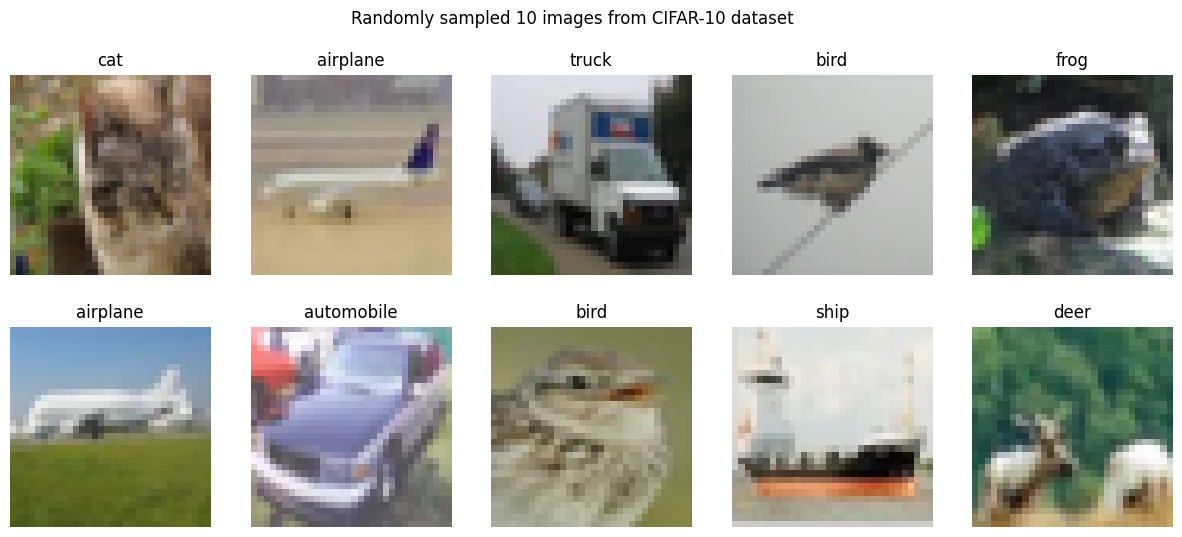

In [57]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Randomly sampled 10 images from CIFAR-10 dataset')
axs = axs.ravel()

for i in range(10):
  index = np.random.randint(0, dataset_size)
  img, label = cifar10[index]
  axs[i].axis('off')
  axs[i].imshow(img)
  axs[i].set_title(cifar10_classes[label])

plt.show()

# Load Model

## Load Architecture

In [58]:
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v2.classifier[-1] = nn.Linear(in_features=1280,
                                        out_features=len(cifar10_classes))

resnet_18 = models.resnet18(pretrained=True)
resnet_18.fc = nn.Linear(in_features=512,
                                out_features=len(cifar10_classes))

In [59]:
mobilenet_v2

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [60]:
resnet_18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Self Designed Modules

In [61]:
# class SimAM(nn.Module):
#     def __init__(self, coeff_lambda=1e-4):
#         super(SimAM, self).__init__()
#         self.coeff_lambda = coeff_lambda
#         self.activation = nn.Sigmoid()

#     def forward(self, X):
#         """
#         X: input tensor with shape (batch_size, num_channels, height, width)
#         """
#         # assert X.dim() == 4, "shape of X must have 4 dimension"

#         # # spatial size
#         # n = X.shape[2] * X.shape[3] - 1
#         # n = 1 if n==0 else n

#         # # square of (t - u)
#         # d = (X - X.mean(dim=[2,3], keepdim=True)).pow(2)

#         # # d.sum() / n is channel variance
#         # v = d.sum(dim=[2,3], keepdim=True) / n

#         # # E_inv groups all importance of X
#         # E_inv = d / (4 * (v + self.coeff_lambda)) + 0.5

#         # # return attended features
#         # return X * F.sigmoid(E_inv)

#         b, c, h, w = X.size()

#         n = w * h - 1

#         x_minus_mu_square = (X - X.mean(dim=[2,3], keepdim=True)).pow(2)
#         y = x_minus_mu_square / (4 * (x_minus_mu_square.sum(dim=[2,3], keepdim=True) / n + self.coeff_lambda)) + 0.5

#         return X * self.activation(y)

# class Squeezer(nn.Module):
#   def __init__(self):
#     super(Squeezer, self).__init__()

#   def forward(self, x):
#     return torch.squeeze(x, dim=-1)

In [62]:
class simam_module(torch.nn.Module):
    def __init__(self, channels = None, e_lambda = 1e-4):
        super(simam_module, self).__init__()

        self.activaton = nn.Sigmoid()
        self.e_lambda = e_lambda

    def __repr__(self):
        s = self.__class__.__name__ + '('
        s += ('lambda=%f)' % self.e_lambda)
        return s

    @staticmethod
    def get_module_name():
        return "simam"

    def forward(self, x):

        b, c, h, w = x.size()

        n = w * h - 1

        x_minus_mu_square = (x - x.mean(dim=[2,3], keepdim=True)).pow(2)
        y = x_minus_mu_square / (4 * (x_minus_mu_square.sum(dim=[2,3], keepdim=True) / n + self.e_lambda)) + 0.5

        return x * self.activaton(y)

## Model Surgery

In [63]:
# resnet_18_simam = nn.Sequential()

# for name, module in resnet_18.named_children():
#   if name == 'features':
    # feature_seq = nn.Sequential()
    # resnet_18_simam.add_module(name, feature_seq)

    # for n0, m0 in module.named_children():
      # if m0._get_name() == "Conv2dNormActivation":
      #   block = nn.Sequential()
      #   feature_seq.add_module(n0, block)

      #   for n1, m1 in m0.named_children():
      #     block.add_module(n1, m1)
      #     # if (m1._get_name() == "Conv2d" or
      #     #     m1._get_name() == "BatchNorm2d"):
      #     if m1._get_name() == "Conv2d":
      #       block.add_module(f'{n1}_simam', SimAM())

      # elif m0._get_name() == "InvertedResidual":
      #   block_big = nn.Sequential()                                             # BLOCKNAME: InvertedResidual
      #   feature_seq.add_module(n0, block_big)

      #   for n1, m1 in m0.named_children():
      #     block_med = nn.Sequential()                                           # BLOCKNAME: Sequential
      #     block_big.add_module(n1, block_med)

      #     for n2, m2 in m1.named_children():
      #       if m2._get_name() == "Conv2dNormActivation":
      #         block_small = nn.Sequential()                                     # BLOCKNAME: Conv2dNormActivation
      #         block_med.add_module(n2, block_small)

      #         for n3, m3 in m2.named_children():
      #           block_small.add_module(n3, m3)
      #           # if (m3._get_name() == "Conv2d" or
      #           #     m3._get_name() == "BatchNorm2d"):
      #           if m3._get_name() == "Conv2d":
      #             block_small.add_module(f'{n3}_simam', SimAM())
      #       else:
      #         block_med.add_module(n2, m2)
      #         # if (m2._get_name() == "Conv2d" or
      #         #   m2._get_name() == "BatchNorm2d"):
      #         if m2._get_name() == "Conv2d":
      #           block_med.add_module(f'{n2}_simam', SimAM())

#       else:
#         raise ValueError("Sum ting wong")
#   else:
    # mobilenet_v2_simam.add_module('squeeze0', Squeezer())
    # mobilenet_v2_simam.add_module('squeeze1', Squeezer())

    # mobilenet_v2_simam.add_module(name, module)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# mobilenet_v2_simam = mobilenet_v2_simam.to(device)


In [64]:
# resnet_18_simam = nn.Sequential()

# # Iterate through the model's layers (once)
# for name, module in resnet_18.named_children():
#     if name == 'conv1':
#         resnet_18_simam.add_module(name, module)
#         resnet_18_simam.add_module(f'{name}_simam', SimAM())  # Add SiMAM after first convolution

#     elif isinstance(module, nn.Sequential):  # Check for BasicBlocks
#         block = nn.Sequential()  # Create a new Sequential for the modified block
#         resnet_18_simam.add_module(name, block)
#         for n0, m0 in module.named_children():
#             block_2 = nn.Sequential()
#             block.add_module(n0, block_2)
#             for n1, m1 in m0.named_children():  # Iterate through layers within the block
#                 block_2.add_module(n1, m1)
#                 if n1 == 'downsample':
#                   block_3 = nn.Sequential()
#                   block_2.add_module(n1, block_3)
#                   for n2, m2 in m1.named_children():
#                     block_3.add_module(n2,m2)
#                     if isinstance(m2, nn.Conv2d):  # Add SiMAM after convolutions
#                       block_3.add_module(f'{n1}_simam', SimAM())
#                 if isinstance(m1, nn.Conv2d):  # Add SiMAM after convolutions
#                     block_2.add_module(f'{n1}_simam', SimAM())
#         resnet_18_simam.add_module(name, block)  # Add the modified BasicBlock

#     else:
#         if name in ['avgpool']:
#             resnet_18_simam.add_module('squeeze0', Squeezer())
#             resnet_18_simam.add_module('squeeze1', Squeezer())
#         resnet_18_simam.add_module(name, module)

# # Move model to GPU if available
# device = "cuda" if torch.cuda.is_available() else "cpu"
# resnet_18_simam = resnet_18_simam.to(device)


In [65]:
# resnet_18_simam

In [66]:
def conv3x3(in_channels, ou_channels, stride=1):
    return nn.Conv2d(in_channels, ou_channels, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_channels, ou_channels, stride=1):
    return nn.Conv2d(in_channels, ou_channels, kernel_size=1, stride=stride, padding=0, bias=False)


# Basic Block in ResNet for CIFAR
class BasicBlock(nn.Module):

    EXPANSION = 1

    def __init__(self, in_channels, ou_channels, stride=1, attention_module=None):
        super(BasicBlock, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = conv3x3(in_channels, ou_channels, stride=stride)
        self.bn1 = nn.BatchNorm2d(ou_channels)

        self.conv2 = conv3x3(ou_channels, ou_channels * self.EXPANSION, stride=1)
        self.bn2 = nn.BatchNorm2d(ou_channels * self.EXPANSION)

        if attention_module is not None:
            if type(attention_module) == functools.partial:
                module_name = attention_module.func.get_module_name()
            else:
                module_name = attention_module.get_module_name()


            if module_name == "simam":
                self.conv2 = nn.Sequential(
                    self.conv2,
                    attention_module(ou_channels * self.EXPANSION)
                )
            else:
                self.bn2 = nn.Sequential(
                    self.bn2,
                    attention_module(ou_channels * self.EXPANSION)
                )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != ou_channels * self.EXPANSION:
            self.shortcut = nn.Sequential(
                conv1x1(in_channels, ou_channels * self.EXPANSION, stride=stride),
                nn.BatchNorm2d(ou_channels * self.EXPANSION)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)

        return self.relu(out)

# Bottlenect in ResNet for CIFAR
class BottleNect(nn.Module):

    EXPANSION = 4

    def __init__(self, in_channels, ou_channels, stride=1, attention_module=None):
        super(BottleNect, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = conv1x1(in_channels, ou_channels, stride=1)
        self.bn1 = nn.BatchNorm2d(ou_channels)

        self.conv2 = conv3x3(ou_channels, ou_channels, stride=stride)
        self.bn2 = nn.BatchNorm2d(ou_channels)

        self.conv3 = conv1x1(ou_channels, ou_channels * self.EXPANSION, stride=1)
        self.bn3 = nn.BatchNorm2d(ou_channels * self.EXPANSION)

        if attention_module is not None:
            if type(attention_module) == functools.partial:
                module_name = attention_module.func.get_module_name()
            else:
                module_name = attention_module.get_module_name()

            if module_name == "simam":
                self.conv2 = nn.Sequential(
                    self.conv2,
                    attention_module(ou_channels * self.EXPANSION)
                )
            else:
                self.bn3 = nn.Sequential(
                    self.bn3,
                    attention_module(ou_channels * self.EXPANSION)
                )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != ou_channels * self.EXPANSION:
            self.shortcut = nn.Sequential(
                conv1x1(in_channels, ou_channels * self.EXPANSION, stride=stride),
                nn.BatchNorm2d(ou_channels * self.EXPANSION)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)

        return self.relu(out)



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_class=10):
        super(ResNet, self).__init__()

        self.num_class = num_class
        self.in_channels = num_filters = 16

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)

        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.layer1 = self._make_layer(block, self.in_channels, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, int(num_filters*2), num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, int(num_filters*4), num_blocks[2], stride=2)
        self.linear = nn.Linear(int(num_filters*4*block(16,16,1).EXPANSION), num_class)

    def _make_layer(self, block, ou_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, ou_channels, stride))
            self.in_channels = int(ou_channels * block(16,16,1).EXPANSION)
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNetWrapper(num_blocks, num_class=10, block=None, attention_module=None):

    b = lambda in_planes, planes, stride: \
        block(in_planes, planes, stride, attention_module=attention_module)

    return ResNet(b, num_blocks, num_class=num_class)


def ResNet20(num_class=10, block=None, attention_module=None):
    return ResNetWrapper(
        num_blocks = [3, 3, 3],
        num_class = num_class,
        block = block,
        attention_module = attention_module)

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [68]:
resnet_20 = ResNet20(block=BasicBlock)
resnet_20_simam = ResNet20(block=BasicBlock, attention_module=simam_module)
resnet_20.to(device)
resnet_20_simam = resnet_20_simam.to(device)

# Training

In [69]:
# resnet_18 = models.resnet18(pretrained=True)
# resnet_18.fc = nn.Linear(in_features=512,
#                                 out_features=len(cifar10_classes))

## Preprocessing

In [70]:
# def clamp_to_01(x):
#     return torch.clamp(x, 0, 1)

# # Create a transform using transforms.Lambda
# clamp_transform = transforms.Lambda(lambda x: clamp_to_01(x))

In [71]:
# transform = transforms.Compose([
#     transforms.Pad(4),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32),
#     transforms.ToTensor(),
#     # transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
#     # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# ])

In [72]:
# def renormalize(tensor):
#         minFrom= tensor.min()
#         maxFrom= tensor.max()
#         minTo = 0
#         maxTo=1
#         return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))

In [73]:
# fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# fig.suptitle('Randomly sampled 10 images from CIFAR-10 dataset')
# axs = axs.ravel()

# for i in range(3):
#   index = np.random.randint(0, dataset_size)
#   axs[3*i].axis('off')
#   axs[3*i+1].axis('off')
#   axs[3*i+2].axis('off')

#   img_original, label = cifar10[index]
#   img_transformed = transform(img_original)
#   img_clamped = clamp_to_01(img_transformed)
#   img_scaled = renormalize(img_transformed)

#   axs[3*i].imshow(img_original)
#   axs[3*i].set_title(f'{cifar10_classes[label]} orig')

#   axs[3*i+1].imshow(transforms.ToPILImage()(img_clamped))
#   axs[3*i+1].set_title(f'{cifar10_classes[label]} clamped')

#   axs[3*i+2].imshow(transforms.ToPILImage()(img_scaled))
#   axs[3*i+2].set_title(f'{cifar10_classes[label]} scaled')
# plt.show()

In [74]:
def Scale_0_1(tensor):
  return (tensor-tensor.min())/(tensor.max()-tensor.min())
Scale_0_1_transform = transforms.Lambda(lambda x: Scale_0_1(x))

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Scale_0_1_transform
])

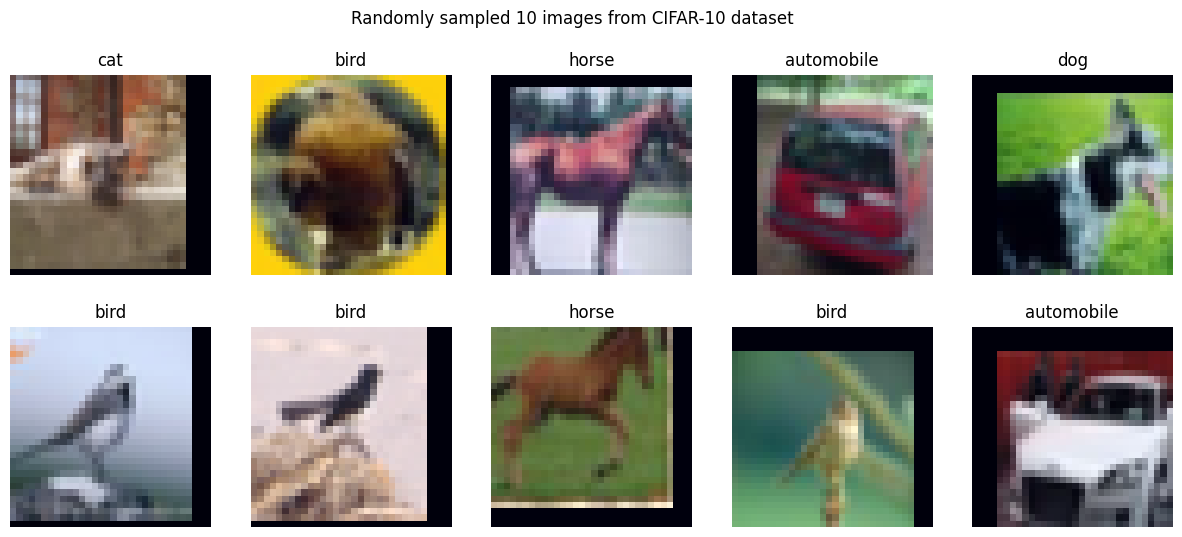

In [75]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Randomly sampled 10 images from CIFAR-10 dataset')
axs = axs.ravel()

for i in range(10):
  index = np.random.randint(0, dataset_size)
  axs[i].axis('off')
  img, label = cifar10[index]
  img = transform(img)
  axs[i].imshow(transforms.ToPILImage()(img))
  axs[i].set_title(cifar10_classes[label])

plt.show()

## Optimizer

In [76]:
learning_rate = 0.1
optimizer = optim.SGD(resnet_20_simam.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      weight_decay=5e-4)

## DataLoader

In [77]:
normlizer = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

cifar10_preprocessed = datasets.CIFAR10(data_path, train=True, download=False, transform=transform)
cifar10_val_preprocessed = datasets.CIFAR10(data_path, train=False, download=False, transform=transform)

cifar10_preprocessed_dataloader = [(img, label) for img, label in cifar10_preprocessed]
cifar10_val_preprocessed_dataloader = [(img, label) for img, label in cifar10_val_preprocessed]

In [78]:
train_dataloader = DataLoader(cifar10_preprocessed_dataloader,
                              batch_size=128,
                              shuffle=True,
                              )
val_dataloader = DataLoader(cifar10_val_preprocessed_dataloader,
                            batch_size=128,
                            shuffle=True,
                            )


## Model Fitting

### ResNet20 with SimAM

In [79]:
resnet_20

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (layer1): Sequential(
    (0): BasicBlock(
      (relu): ReLU(inplace=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (relu): ReLU(inplace=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2)

In [80]:
resnet_20_simam

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (layer1): Sequential(
    (0): BasicBlock(
      (relu): ReLU(inplace=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): simam_module(lambda=0.000100)
      )
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (relu): ReLU(inplace=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, e

In [81]:
criterion = nn.CrossEntropyLoss()

global_steps = 0
lr_reduced32k = False
lr_reduced48k = False
lr_reduced64k = False

resnet_20_simam.train()

best_loss = float('inf')  # Initialize best loss as positive infinity
patience = 5  # Number of epochs to wait without improvement

for epoch in range(1, 101):
  for i, (images, labels) in enumerate(train_dataloader):
    # Move tensors to the configured device
    images = images.to(device)
    # labels = F.one_hot(labels, num_classes=len(cifar10_classes))
    # labels = labels.float().to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    # Forward pass
    outputs = resnet_20_simam(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Update learning rate
    if global_steps >= 32000 and not lr_reduced32k:
      learning_rate = learning_rate/10
      optimizer = optim.SGD(resnet_20_simam.parameters(),
                            lr=learning_rate,
                            momentum=0.9,
                            weight_decay=5e-4)
      lr_reduced32k = True

    elif global_steps >= 48000 and not lr_reduced48k:
      learning_rate = learning_rate/10
      optimizer = optim.SGD(resnet_20_simam.parameters(),
                            lr=learning_rate,
                            momentum=0.9,
                            weight_decay=5e-4)
      lr_reduced48k = True
    elif global_steps >= 64000 and not lr_reduced64k:
      learning_rate = learning_rate/10
      optimizer = optim.SGD(resnet_20.parameters(),
                            lr=learning_rate,
                            momentum=0.9,
                            weight_decay=5e-4)
      lr_reduced64k = True

  # Print statistics
  if epoch % 1 == 0:
    print(f"Epoch {epoch}/{100}, Loss: {loss.item():.4f}")

  # Early stopping
  if loss.item() < best_loss:
    best_loss = loss.item()
    current_patience = 0  # Reset patience counter on improvement
  else:
    current_patience += 1

  if current_patience >= patience:
    print(f"Early stopping at epoch {epoch} due to no improvement in validation loss for {patience} epochs.")
    break

print(f'Final Loss: {loss.item():.4f}')

Epoch 1/100, Loss: 1.3419
Epoch 2/100, Loss: 1.0440
Epoch 3/100, Loss: 0.8583
Epoch 4/100, Loss: 0.7177
Epoch 5/100, Loss: 0.5776
Epoch 6/100, Loss: 0.6202
Epoch 7/100, Loss: 0.6145
Epoch 8/100, Loss: 0.6559
Epoch 9/100, Loss: 0.7316
Epoch 10/100, Loss: 0.5717
Epoch 11/100, Loss: 0.5594
Epoch 12/100, Loss: 0.7262


KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0

resnet_20_simam.eval()
with torch.no_grad():
  for i, (images, labels) in enumerate(val_dataloader):
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet_20_simam(images)
    pred = torch.argmax(outputs, dim=1)

    total += labels.shape[0]
    correct += int((pred == labels).sum())

print("Accuracy: ", correct/total)

### ResNet20 without SimAM

In [ ]:
learning_rate = 0.1
optimizer = optim.SGD(resnet_20.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

global_steps = 0
lr_reduced32k = False
lr_reduced48k = False
lr_reduced64k = False

resnet_20.train()

best_loss = float('inf')
patience = 5

for epoch in range(1, 101):
  for i, (images, labels) in enumerate(train_dataloader):
    #loss Move tensors to the configured device
    images = images.to(device)
    # labels = F.one_hot(labels, num_classes=len(cifar10_classes))
    # labels = labels.float().to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    # Forward pass
    outputs = resnet_20(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    global_steps += labels.shape[0]
    # Update learning rate
    if global_steps >= 32000 and not lr_reduced32k:
      learning_rate = learning_rate/10
      optimizer = optim.SGD(resnet_20.parameters(),
                            lr=learning_rate,
                            momentum=0.9,
                            weight_decay=5e-4)
      lr_reduced32k = True
    elif global_steps >= 48000 and not lr_reduced48k:
      learning_rate = learning_rate/10
      optimizer = optim.SGD(resnet_20.parameters(),
                            lr=learning_rate,
                            momentum=0.9,
                            weight_decay=5e-4)
      lr_reduced48k = True
    elif global_steps >= 64000 and not lr_reduced64k:
      learning_rate = learning_rate/10
      optimizer = optim.SGD(resnet_20.parameters(),
                            lr=learning_rate,
                            momentum=0.9,
                            weight_decay=5e-4)
      lr_reduced64k = True


  # Print statistics
  if epoch % 1 == 0:
    print(f"Epoch {epoch}/{100}, Loss: {loss.item():.4f}")

  # Early stopping
  if loss.item() < best_loss:
    best_loss = loss.item()
    current_patience = 0  # Reset patience counter on improvement
  else:
    current_patience += 1

  if current_patience >= patience:
    print(f"Early stopping at epoch {epoch} due to no improvement in validation loss for {patience} epochs.")
    break

print(f'Final Loss: {loss.item():.4f}')

In [ ]:
correct = 0
total = 0

resnet_20.eval()
with torch.no_grad():
  for i, (images, labels) in enumerate(val_dataloader):
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet_20(images)
    pred = torch.argmax(outputs, dim=1)

    total += labels.shape[0]
    correct += int((pred == labels).sum())

print("Accuracy: ", correct/total)